In [0]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

# Download Dataset

In [3]:
!wget http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz -O /tmp/WISDM_ar_latest.tar.gz

--2019-05-31 19:09:23--  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘/tmp/WISDM_ar_latest.tar.gz’

/tmp/WISDM_ar_lates 100%[===================>]  10.88M  23.5MB/s    in 0.5s    

2019-05-31 19:09:23 (23.5 MB/s) - ‘/tmp/WISDM_ar_latest.tar.gz’ saved [11404612/11404612]



In [0]:
import os


WISDM_DATASET_DIR = "/content/wisdm-dataset"

if not os.path.exists(WISDM_DATASET_DIR):
  os.makedirs(WISDM_DATASET_DIR)

In [0]:
# Clean directory

!rm -rf $WISDM_DATASET_DIR
!mkdir $WISDM_DATASET_DIR

In [6]:
!tar -xzvf /tmp/WISDM_ar_latest.tar.gz -C $WISDM_DATASET_DIR

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [7]:
!ls $WISDM_DATASET_DIR

WISDM_ar_v1.1


In [8]:
!ls "$WISDM_DATASET_DIR/WISDM_ar_v1.1"

readme.txt		     WISDM_ar_v1.1_trans_about.txt
WISDM_ar_v1.1_raw_about.txt  WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1_raw.txt


In [0]:
!rm -rf /tmp/WISDM_ar_latest.tar.gz

# Data Ingestion

In [0]:
import os
import pandas as pd


def read_data(file_path):
  file_path = os.path.join(WISDM_DATASET_DIR, "WISDM_ar_v1.1", file_path)

  column_names = ['user','activity', 'timestamp', 'x', 'y', 'z']
  df = pd.read_csv(file_path, header=None, names=column_names)
  # Last column has a ";" character which must be removed ...
  df['z'].replace(regex=True, inplace=True, to_replace=';', value='')
  
  df['x'] = df['x'].astype('float32')
  df['y'] = df['y'].astype('float32')
  df['z'] = df['z'].astype('float32')
  
  df = df.round({'x': 4, 'y': 4, 'z': 4})
  return df


# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

In [11]:
df.head()

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.6946,12.680500,0.5040
1,33,Jogging,49106062271000,5.0123,11.264000,0.9534
2,33,Jogging,49106112167000,4.9033,10.882700,-0.0817
3,33,Jogging,49106222305000,-0.6129,18.496401,3.0237
4,33,Jogging,49106332290000,-1.1850,12.108500,7.2052


In [12]:
len(df)

1098204

In [13]:
# This is very important otherwise the model will not fit and loss
# will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
len(df)

1098203

## Label Encoding

In [0]:
ACTIVITY_LABELS = [
    'Walking',
    'Upstairs',
    'Downstairs',
    'Sitting',
    'Standing',
    'Jogging',
]

df['label'] = -1

for i, label in enumerate(ACTIVITY_LABELS):
  df.loc[df['activity'] == label, 'label'] = i

In [0]:
df['label'].unique()

array([5, 0, 1, 2, 3, 4])

## Data Preperations

In [0]:
SAMPLE_SIZE = 80
NUM_SENSORS = 3
STRIDE = SAMPLE_SIZE // 2

NUM_CLASSES = len(ACTIVITY_LABELS)

In [0]:
from scipy import stats


def create_segments_and_labels(df, sample_size, stride):
    segments = []
    labels = []
    for i in range(0, len(df) - sample_size, stride):
        xs = df['x'].values[i:i + sample_size]
        ys = df['y'].values[i:i + sample_size]
        zs = df['z'].values[i:i + sample_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + sample_size])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments).reshape(-1, sample_size, 3)
    labels = np.asarray(labels)

    return reshaped_segments, labels

  
X, y = create_segments_and_labels(df, SAMPLE_SIZE, STRIDE)

In [0]:
X.shape

(27454, 80, 3)

# Data Analysis

In [0]:
class_0 = np.argwhere(y == 0).flatten()
class_1 = np.argwhere(y == 1).flatten()
class_2 = np.argwhere(y == 2).flatten()
class_3 = np.argwhere(y == 3).flatten()
class_4 = np.argwhere(y == 4).flatten()
class_5 = np.argwhere(y == 5).flatten()

<BarContainer object of 6 artists>

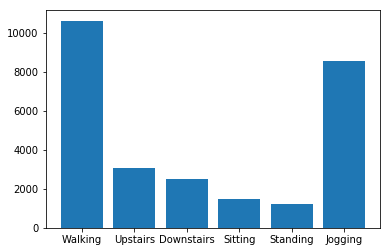

In [0]:
plt.bar(
    ACTIVITY_LABELS,
    [
        len(class_0),
        len(class_1),
        len(class_2),
        len(class_3),
        len(class_4),
        len(class_5)
    ]
)

In [0]:
random.seed(0)

random.shuffle(class_0)
random.shuffle(class_5)


C0 = X[class_0[:4000]]
C1 = X[class_1]
C2 = X[class_2]
C3 = X[class_3]
C4 = np.vstack([X[class_4]] * 2)
C5 = X[class_5[:4000]]

<BarContainer object of 6 artists>

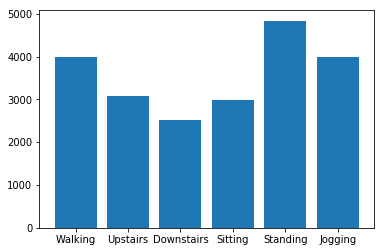

In [0]:
plt.bar(
    ACTIVITY_LABELS,
    [
        len(C0),
        len(C1),
        len(C2),
        len(C3),
        len(C4),
        len(C5)
    ]
)

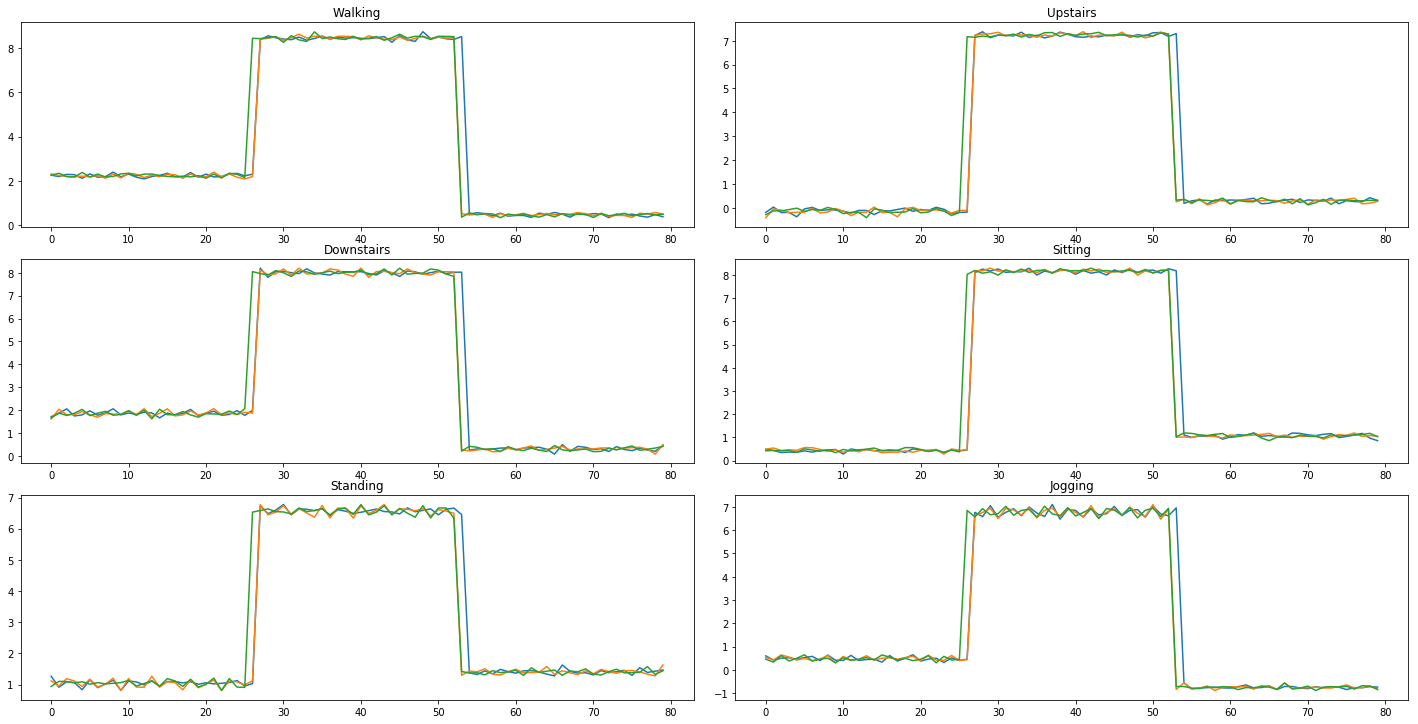

In [0]:
all_activities = [C0, C1, C2, C3, C4, C5]


fig, axes = plt.subplots(3, 2, figsize=(20, 10))
fig.tight_layout()

for i, activities in enumerate(all_activities):
  mean = activities.mean(axis=0)
  
  axes[i // 2, i % 2].plot(mean[:,0])
  axes[i // 2, i % 2].plot(mean[:,1])
  axes[i // 2, i % 2].plot(mean[:,2])
  
  axes[i // 2, i % 2].set_title(ACTIVITY_LABELS[i])

In [0]:
X_n = np.vstack([C0, C1, C2, C3, C4, C5])
y_n = np.concatenate([
    [0] * C0.shape[0],
    [1] * C1.shape[0],
    [2] * C2.shape[0],
    [3] * C3.shape[0],
    [4] * C4.shape[0],
    [5] * C5.shape[0],
])

In [0]:
len(X_n), len(y_n)

(21412, 21412)

# Data Split

In [0]:
class_0 = np.argwhere(y_n == 0).flatten()
class_1 = np.argwhere(y_n == 1).flatten()
class_2 = np.argwhere(y_n == 2).flatten()
class_3 = np.argwhere(y_n == 3).flatten()
class_4 = np.argwhere(y_n == 4).flatten()
class_5 = np.argwhere(y_n == 5).flatten()

In [0]:
print("Total Records:", X_n.shape[0])

class_sample_size = int(X_n.shape[0] * 0.1 / 6)
print("Test Sample:", class_sample_size * 6)

Total Records: 21412
Test Sample: 2136


In [0]:
random.seed(0)

random.shuffle(class_0)
random.shuffle(class_1)
random.shuffle(class_2)
random.shuffle(class_3)
random.shuffle(class_4)
random.shuffle(class_5)


sub0 = class_0[:class_sample_size]
sub1 = class_1[:class_sample_size]
sub2 = class_2[:class_sample_size]
sub3 = class_3[:class_sample_size]
sub4 = class_4[:class_sample_size]
sub5 = class_5[:class_sample_size]

In [0]:
X_test = np.concatenate([
    X_n[sub0], X_n[sub1], X_n[sub2], X_n[sub3], X_n[sub4], X_n[sub5]
])
X_test.shape

(2136, 80, 3)

In [0]:
y_test = np.hstack([
    y_n[sub0], y_n[sub1], y_n[sub2], y_n[sub3], y_n[sub4], y_n[sub5]
])
y_test.shape

(2136,)

In [0]:
X_train = np.delete(X_n, [sub0, sub1, sub2, sub3, sub4, sub5], axis=0)
y_train = np.delete(y_n, [sub0, sub1, sub2, sub3, sub4, sub5], axis=0)
X_train.shape

(19276, 80, 3)

In [0]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (19276, 80, 3)
y_train: (19276,)
X_test: (2136, 80, 3)
y_test: (2136,)


In [0]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# Training


## Encoding

In [0]:
from keras.utils import np_utils


y_test_hot = np_utils.to_categorical(y_test, NUM_CLASSES)
y_train_hot = np_utils.to_categorical(y_train, NUM_CLASSES)

Using TensorFlow backend.


## Build Model

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import (
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, Activation, Flatten,
)

K.clear_session()

model = Sequential()

model.add(Flatten(input_shape=(SAMPLE_SIZE, NUM_SENSORS)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               61696     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 95,366
Trainable params: 95,366
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(
    x=X_train,
    y=y_train_hot,
    batch_size=32,
    epochs=30,
    verbose=2
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 3s - loss: 1.4628 - acc: 0.5023
Epoch 2/30
 - 2s - loss: 0.8521 - acc: 0.6933
Epoch 3/30
 - 2s - loss: 0.6477 - acc: 0.7684
Epoch 4/30
 - 2s - loss: 0.5445 - acc: 0.8064
Epoch 5/30
 - 2s - loss: 0.4471 - acc: 0.8437
Epoch 6/30
 - 2s - loss: 0.3906 - acc: 0.8654
Epoch 7/30
 - 2s - loss: 0.3379 - acc: 0.8851
Epoch 8/30
 - 2s - loss: 0.3192 - acc: 0.8927
Epoch 9/30
 - 2s - loss: 0.2678 - acc: 0.9101
Epoch 10/30
 - 2s - loss: 0.2522 - acc: 0.9160
Epoch 11/30
 - 2s - loss: 0.2398 - acc: 0.9213
Epoch 12/30
 - 2s - loss: 0.2149 - acc: 0.9343
Epoch 13/30
 - 2s - loss: 0.2172 - acc: 0.9308
Epoch 14/30
 - 2s - loss: 0.1873 - acc: 0.9394
Epoch 15/30
 - 2s - loss: 0.1853 - acc: 0.9430
Epoch 16/30
 - 2s - loss: 0.1965 - acc: 0.9407
Epoch 17/30
 - 2s - loss: 0.1771 - acc: 0.9435
Epoch 18/30
 - 2s - loss: 0.1419 - acc: 0.9556
Epoch 19/30
 - 2s - loss: 0.1642 - acc: 0.9527
Epoch 20/30
 - 2s - loss: 0.1392 - acc: 0.9577
Epoch 21/30
 - 2s - l

In [0]:
model.evaluate(x=X_test, y=y_test_hot, batch_size=16, verbose=2) #loss and accuracy

[1.357151055687599, 0.8033707865168539]

In [0]:
from sklearn.metrics import classification_report


y_pred_train = model.predict(X_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3644
           1       0.98      0.94      0.96      2719
           2       0.99      0.90      0.95      2151
           3       0.96      0.94      0.95      2638
           4       0.95      0.98      0.97      4480
           5       0.96      0.96      0.96      3644

   micro avg       0.96      0.96      0.96     19276
   macro avg       0.96      0.95      0.96     19276
weighted avg       0.96      0.96      0.96     19276



In [0]:
from sklearn.metrics import classification_report


y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
print(classification_report(y_test, max_y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       356
           1       0.81      0.69      0.75       356
           2       0.85      0.65      0.73       356
           3       0.80      0.78      0.79       356
           4       0.86      0.98      0.92       356
           5       0.81      0.85      0.83       356

   micro avg       0.80      0.80      0.80      2136
   macro avg       0.81      0.80      0.80      2136
weighted avg       0.81      0.80      0.80      2136



# Real-world Dataset

## Download from Drive

In [0]:
from google.colab import auth

auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build

drive_service = build('drive', 'v3')
del build

In [0]:
import tqdm
from googleapiclient.http import MediaIoBaseDownload


SELF_DATASET_DIR = "/content/har-self-dataset"


if not os.path.exists(SELF_DATASET_DIR):
  os.makedirs(SELF_DATASET_DIR)

  
def download_file(file_id, output_filename):
  request = drive_service.files().get_media(fileId=file_id)
  
  with open(os.path.join(SELF_DATASET_DIR, output_filename), "wb") as f:
    downloader = MediaIoBaseDownload(f, request)
    pbar = tqdm.tqdm(total=100, desc=output_filename)
  
    done = False
    while done is False:
      status, done = downloader.next_chunk()
      pbar.update(max(100, status.progress() * 100))


DATASET_FILES = [
    ("1i6XT0_5lWgryREwahtf1yjIaAM_BTLF9", "recording_1.csv"),
    ("1ZpadESchBbvA3KUkR-gG61wSfbn2UE89", "recording_2.csv")
]


for file_id, file_name in DATASET_FILES:
    download_file(file_id, file_name)


recording_2.csv: 100%|██████████| 100/100 [00:01<00:00, 96.61it/s]


In [0]:
!ls $SELF_DATASET_DIR

recording_1.csv  recording_2.csv  recording_3.csv


## Evaluate

In [0]:
import pandas as pd


def load_recording(filename):
  df = pd.read_csv(os.path.join(SELF_DATASET_DIR, filename))
  return df.values

  
r = load_recording('recording_2.csv')

In [0]:
r1 = r[:,:3]

In [0]:
def conv_recording(values, stride=None, sample_size=SAMPLE_SIZE):
  layers = []
  if stride is None:
    stride = sample_size // 2
  
  i = sample_size
  while i < values.shape[0]:
    layers.append(values[i - sample_size:i])
    i += stride

  return np.array(layers)


r_batches = conv_recording(r1)
r_batches.shape

(393, 80, 3)

In [0]:
def assign_labels(predictions):
  return np.array([
      ACTIVITY_LABELS[class_]
      for class_ in np.argmax(predictions, axis=1)
  ])

In [0]:
assign_labels(model.predict(r_batches))

In [0]:
import keras
from datetime import datetime
import tensorflow as tf

version = datetime.now().isoformat()
keras_file = "model_wisdm_{}.h5".format(version)
tflite_file = "model_wisdm_{}.tflite".format(version)

keras.models.save_model(model, keras_file)

converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()

with open(tflite_file, "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.


In [0]:
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': tflite_file,
  'mimeType': 'application/octet-stream'
}
media = MediaFileUpload(
    tflite_file,
    mimetype='application/octet-stream',
    resumable=True
)

created = drive_service.files().create(
    body=file_metadata,
    media_body=media,
    fields='id'
).execute()

print('File ID: {}'.format(created.get('id')))

File ID: 1p7lgcsuv3hSHulAgM9KsXOFD7-XDNVm6
